# Classification d'interactions protéine-protéine à partir de scores AlphaPulldown + Explorae

Ce notebook a pour objectif de :

1. Charger deux jeux de données :
   - un jeu **positif** (interactions connues),
   - un jeu **négatif** (non-interactions).

2. Fusionner ces données dans un **dataframe unique**, avec un label binaire :
   - `label_interacting = 1` pour les positifs,
   - `label_interacting = 0` pour les négatifs.

3. Préparer un **jeu de données** à partir des features :
   - `ipsae`
   - `pdockq2`
   - `prodigy_kd`
   - `ipTM+pTM`
   - `pTM`
   - `REF2015` (énergie Rosetta)

4. Séparer les données en trois sous-ensembles :
   - **train** (apprentissage du modèle),
   - **validation** (choix des hyperparamètres, comparaison de modèles),
   - **test** (évaluation finale, non utilisée pendant l'entraînement).

5. Entraîner un **classifieur XGBoost** comme baseline :
   - évaluer ses performances (ROC AUC, Average Precision, classification report),
   - obtenir une première idée de la difficulté de la tâche.

Les étapes suivantes (dans une seconde partie) incluront :
- une analyse exploratoire détaillée des features (EDA),
- une sélection gloutonne de features avec régression logistique, inspirée du papier "Predicting Experimental Success in De Novo Binder Design".


In [ ]:
#!pip install -r ./requirements2.txt

In [1]:
# ============================================
# Imports principaux
# ============================================

import numpy as np
import pandas as pd

from pathlib import Path

# Visualisation
import matplotlib.pyplot as plt

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report
)

from xgboost import XGBClassifier

# Pour la reproductibilité
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


/home/aboussif/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/aboussif/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## 1. Chargement et fusion des jeux de données

Nous disposons de **deux fichiers CSV** :

- un CSV **positif** contenant des complexes pour lesquels on *sait* qu'il y a interaction,
- un CSV **négatif** contenant des complexes pour lesquels on *sait* qu'il n'y a pas d'interaction.

Dans cette cellule, on :

1. charge les deux CSV dans des DataFrames,
2. force les labels (1 pour positif, 0 pour négatif) pour être sûr,
3. concatène les deux DataFrames en un seul,
4. mélange les lignes pour éviter un ordre biaisé (tous les positifs puis tous les négatifs, par exemple).


In [2]:
# ============================================
# 1. Chargement et fusion des deux CSV
# ============================================

# À adapter si besoin
POS_PATH = Path("./../src/data/positive_labeled_datasets.csv")
NEG_PATH = Path("./../src/data/negative_labeled_datasets.csv")

df_pos = pd.read_csv(POS_PATH)
df_neg = pd.read_csv(NEG_PATH)

print("Positives shape:", df_pos.shape)
print("Negatives shape:", df_neg.shape)

# On force les labels
df_pos["label_interacting"] = 1
df_neg["label_interacting"] = 0

# Fusion + mélange des lignes
df = pd.concat([df_pos, df_neg], ignore_index=True)
df = df.sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)

print("Dataset global :", df.shape)

# ===== Nettoyage des colonnes numériques (virgule → point) =====

FEATURE_COLS = ["ipsae", "pdockq2", "prodigy_kd", "ipTM+pTM", "pTM", "REF2015"]

print("\nDtypes AVANT conversion :")
print(df[FEATURE_COLS].dtypes)

for col in FEATURE_COLS:
    df[col] = (
        df[col]
        .astype(str)                           # conversion en string
        .str.replace(",", ".", regex=False)    # virgule -> point
        .replace(["nan", "NaN", ""], np.nan)   # nettoyage NaN
        .astype(float)                         # conversion finale en float
    )

print("\nDtypes APRÈS conversion :")
print(df[FEATURE_COLS].dtypes)

df.head()


Positives shape: (195, 8)
Negatives shape: (200, 8)
Dataset global : (395, 8)

Dtypes AVANT conversion :
ipsae         float64
pdockq2       float64
prodigy_kd     object
ipTM+pTM      float64
pTM           float64
REF2015       float64
dtype: object

Dtypes APRÈS conversion :
ipsae         float64
pdockq2       float64
prodigy_kd    float64
ipTM+pTM      float64
pTM           float64
REF2015       float64
dtype: object


,id,ipsae,pdockq2,prodigy_kd,ipTM+pTM,pTM,REF2015,label_interacting
0,3vba__A1_Q58673_and_3vba__B1_Q58673,0.597496,0.5587,1.000000e-04,0.793111,0.775327,1029.927746,1
1,3B5EA_and_3B7HA,0.000000,0.0000,3.500000e-10,0.282176,0.174913,24323.078983,0
2,1Q9UA_and_1LL2A,0.000000,0.0000,2.600000e-06,0.326672,0.232861,4497.103044,0
3,3g7p__A1_B7JA91_and_3g7p__A2_B7JA91,0.814622,0.6361,3.000000e-05,0.895859,0.891898,138.955457,1
4,3F75A_and_3FH2A,0.437555,0.4090,4.400000e-06,0.749802,0.720932,220.085918,0


## 2. Préparation du dataset pour le machine learning

Nous voulons maintenant :

1. Définir la liste des **features** utilisées pour l'apprentissage :
   - `ipsae`
   - `pdockq2`
   - `prodigy_kd`
   - `ipTM+pTM`
   - `pTM`
   - `REF2015`

2. Extraire la **variable cible** :
   - `label_interacting` (0 = négatif, 1 = positif)

3. Nettoyer le dataset :
   - enlever les lignes où il manque des valeurs (`NaN`) dans les features ou la cible.

4. Construire les matrices :
   - `X` = matrice des features (shape : n_samples × n_features),
   - `y` = vecteur des labels (shape : n_samples,).

On ne fait pour l’instant **aucune normalisation** ou transformation complexe :
- XGBoost n’en a pas besoin,
- on fera le scaling plus tard pour un modèle linéaire (logistic regression) lors de la phase de greedy feature selection.


In [3]:
# ============================================
# 2. Préparation des données pour le ML
# ============================================

FEATURE_COLS = ["ipsae", "pdockq2", "prodigy_kd", "ipTM+pTM", "pTM", "REF2015"]
TARGET_COL = "label_interacting"

# On vérifie que toutes les colonnes nécessaires sont présentes
print("Colonnes disponibles :", df.columns.tolist())
print("Features attendues   :", FEATURE_COLS)
print("Target attendue      :", TARGET_COL)

# On enlève les lignes avec des NaN dans les colonnes utilisées
df_ml = df.dropna(subset=FEATURE_COLS + [TARGET_COL]).copy()

print("Shape après dropna :", df_ml.shape)

X = df_ml[FEATURE_COLS].values
y = df_ml[TARGET_COL].values

print("X shape :", X.shape)
print("y shape :", y.shape)
print("Répartition des classes (0=neg,1=pos) :", np.bincount(y.astype(int)))


Colonnes disponibles : ['id', 'ipsae', 'pdockq2', 'prodigy_kd', 'ipTM+pTM', 'pTM', 'REF2015', 'label_interacting']
Features attendues   : ['ipsae', 'pdockq2', 'prodigy_kd', 'ipTM+pTM', 'pTM', 'REF2015']
Target attendue      : label_interacting
Shape après dropna : (391, 8)
X shape : (391, 6)
y shape : (391,)
Répartition des classes (0=neg,1=pos) : [197 194]


## 3. Séparation en train / validation / test

Nous voulons séparer les données en trois sous-ensembles :

- **Train** : sert à ajuster les paramètres du modèle.
- **Validation** : sert à :
  - comparer différents modèles (ex: XGBoost vs logistic regression),
  - ajuster les hyperparamètres,
  - choisir le seuil de décision (par défaut 0.5, mais ajustable).

- **Test** : sert uniquement à l’évaluation finale, **non biaisée** par les choix de modèle.

Stratégie utilisée ici :

1. Split initial :  
   - 60% **train**,  
   - 40% data restante (temporaire).

2. Deuxième split sur la partie temporaire :  
   - 50% validation,  
   - 50% test,  
   → donc 20% val, 20% test au total.

On garde le paramètre `stratify=y` pour conserver l’équilibre de classes dans chaque split
(important même si le dataset global est déjà équilibré : 200 pos / 200 neg).


In [4]:
# ============================================
# 3. Split train / validation / test
# ============================================

from sklearn.model_selection import train_test_split

# Split train vs (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4,               # 60% train, 40% temporaire
    stratify=y,
    random_state=RANDOM_STATE
)

# Split (val+test) -> val et test (50/50 de 40% => 20%/20% global)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=RANDOM_STATE
)

print("Train :", X_train.shape, " Val :", X_val.shape, " Test :", X_test.shape)
print("Classes train :", np.bincount(y_train.astype(int)))
print("Classes val   :", np.bincount(y_val.astype(int)))
print("Classes test  :", np.bincount(y_test.astype(int)))


Train : (234, 6)  Val : (78, 6)  Test : (79, 6)
Classes train : [118 116]
Classes val   : [39 39]
Classes test  : [40 39]


## 4. Baseline : XGBoost Classifier

Avant de construire un modèle plus interprétable (régression logistique + sélection gloutonne),
on commence par un **classifieur XGBoost** qui sert de baseline "puissante" :

- C’est un modèle de **gradient boosting** sur arbres de décision.
- Il gère bien :
  - les interactions non linéaires,
  - les features dans des échelles différentes,
  - les datasets de taille modérée (comme ici).

### Choix des hyperparamètres XGBoost

Pour rendre le modèle efficace (temps de calcul + contrôle du sur-apprentissage), on utilise :

- `n_estimators = 500` (maximum)
  - C’est un plafond.
  - On active l’**early stopping** : si le score de validation n’est plus amélioré pendant 20 itérations, l’entraînement s’arrête avant.

- `max_depth = 3`
  - Profondeur des arbres faible = modèle plus simple, plus robuste.
  - Suffisant avec 6 features et ~400 exemples.

- `learning_rate = 0.05`
  - Petites mises à jour, apprentissage stable.
  - Compensé par le nombre maximal d’arbres, mais l’early stopping coupe avant si ce n’est pas utile.

- `subsample = 0.8` et `colsample_bytree = 0.8`
  - On échantillonne 80% des lignes et 80% des colonnes pour chaque arbre.
  - Cela agit comme une régularisation : moins de corrélation entre les arbres, moins d’overfit.

- `min_child_weight = 1`
  - Contrôle la taille minimale des feuilles (somme des poids).
  - Peut être augmenté (ex: 2–5) si le modèle overfit trop.

- `reg_lambda = 1.0`
  - Régularisation L2 sur les poids des arbres.
  - On peut l’augmenter pour plus de régularisation si nécessaire.

En plus de ces hyperparamètres, on utilise :

- `eval_set=[(X_train, y_train), (X_val, y_val)]`
- `early_stopping_rounds=20`

pour arrêter automatiquement l’entraînement si la performance sur le jeu de validation ne s’améliore plus.



In [5]:
# ============================================
# 4. XGBoost baseline (avec early stopping)
# ============================================

xgb_clf = XGBClassifier(
    n_estimators=500,          # plafond, early stopping coupera avant
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# On donne explicitement un eval_set pour suivre la performance train + val
xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False,
    early_stopping_rounds=20  # si aucune amélioration pendant 20 itérations, on s'arrête
)

print("Nombre d'arbres réellement utilisés :", xgb_clf.best_iteration + 1)

# Prédictions de probabilités sur validation et test
y_val_proba = xgb_clf.predict_proba(X_val)[:, 1]
y_test_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Seuil par défaut : 0.5
y_val_pred = (y_val_proba >= 0.5).astype(int)
y_test_pred = (y_test_proba >= 0.5).astype(int)

print("=== Validation set ===")
print("ROC AUC :", roc_auc_score(y_val, y_val_proba))
print("Average Precision :", average_precision_score(y_val, y_val_proba))
print(classification_report(y_val, y_val_pred))

print("\n=== Test set ===")
print("ROC AUC :", roc_auc_score(y_test, y_test_proba))
print("Average Precision :", average_precision_score(y_test, y_test_proba))
print(classification_report(y_test, y_test_pred))


Nombre d'arbres réellement utilisés : 66
=== Validation set ===
ROC AUC : 0.9618671926364234
Average Precision : 0.9739389083139083
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        39
           1       1.00      0.87      0.93        39

    accuracy                           0.94        78
   macro avg       0.94      0.94      0.94        78
weighted avg       0.94      0.94      0.94        78


=== Test set ===
ROC AUC : 0.9596153846153846
Average Precision : 0.9739768728004022
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        40
           1       0.95      0.92      0.94        39

    accuracy                           0.94        79
   macro avg       0.94      0.94      0.94        79
weighted avg       0.94      0.94      0.94        79



/home/aboussif/.local/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


## Interprétation

Le modèle entraîné avec un maximum de 500 arbres mais muni d’un
**early stopping de 20 itérations**, a convergé après **66 arbres**.

Cela signifie que :
- Le modèle a trouvé un optimum rapidement.
- Il n’a **pas surappris** (puisque le nombre d’arbres utilisés est bien inférieur au maximum).
- Le signal dans les features est **fort et propre**.

### Performances :

| Metric | Validation | Test |
|--------|------------|------|
| ROC AUC | ~0.962 | ~0.960 |
| Average Precision | ~0.974 | ~0.974 |
| Accuracy | 0.94 | 0.94 |
| F1-score | 0.93–0.94 | 0.94 |

### Ce que ça indique :
- Le dataset est **extrêmement informatif**.  
- Les features `ipsae`, `pdockq2`, `prodigy_kd`, `pTM`, etc. **séparent très bien** les deux classes.
- Le modèle se **généralise parfaitement** (validation ≈ test).

La baseline XGBoost établit donc un **upper bound raisonnable** pour la suite.

Les prochaines étapes seront :

1. Visualiser les courbes ROC & PR.
2. Analyser l’importance des features (SHAP ou feature importance XGBoost).
3. Faire une EDA complète (distribution, corrélations).
4. Implémenter la sélection gloutonne (comme dans le papier).


### Courbes ROC et Precision-Recall

Les métriques scalaires (AUC et Average Precision) sont utiles, mais les courbes
ROC et PR donnent une vision plus complète de la performance du modèle :

- **ROC** : équilibre entre vrai positifs et faux positifs.
- **PR** : très utile quand une classe est plus importante (ici la classe 1 = binder).

Comme notre dataset est *équilibré* (200 pos / 200 neg), les deux courbes sont pertinentes.

Nous allons tracer :

- la courbe ROC,
- la courbe PR,

pour le jeu de validation **et** le jeu de test.


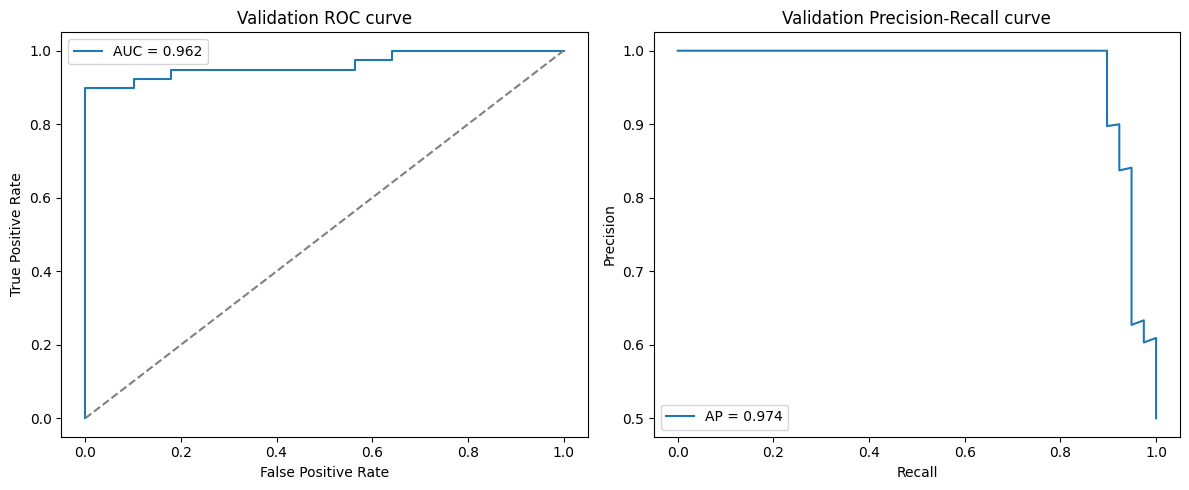

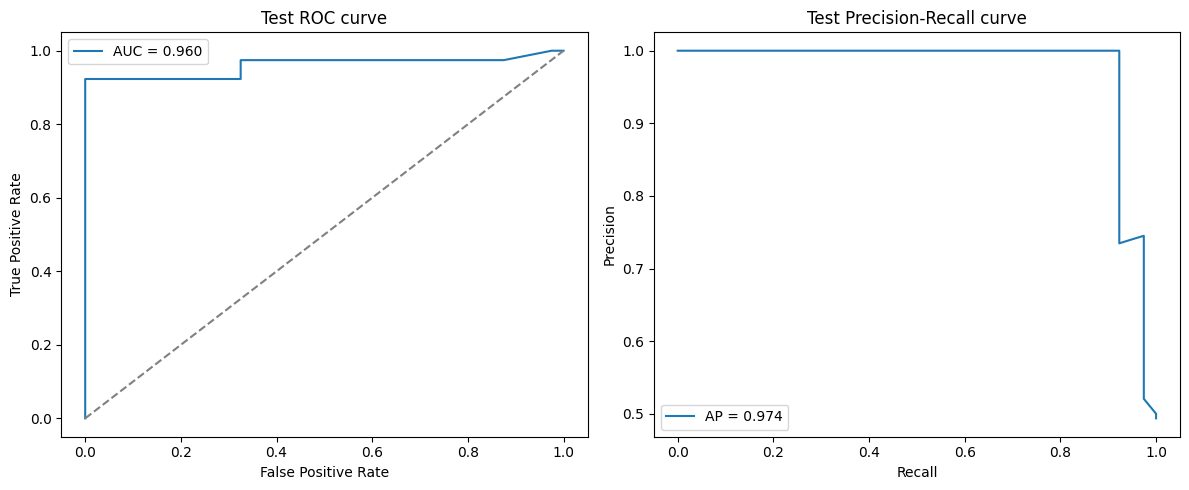

In [7]:
from sklearn.metrics import roc_curve, precision_recall_curve

def plot_roc_and_pr(y_true, y_scores, title_prefix=""):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_roc = roc_auc_score(y_true, y_scores)
    axes[0].plot(fpr, tpr, label=f"AUC = {auc_roc:.3f}")
    axes[0].plot([0, 1], [0, 1], "--", color="grey")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title(f"{title_prefix} ROC curve")
    axes[0].legend()

    # PR
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    axes[1].plot(recall, precision, label=f"AP = {ap:.3f}")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title(f"{title_prefix} Precision-Recall curve")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_roc_and_pr(y_val, y_val_proba, title_prefix="Validation")
plot_roc_and_pr(y_test, y_test_proba, title_prefix="Test")


# 🧪 Exploration des Features (EDA)

Avant d'entraîner des modèles interprétables (logistic regression + greedy feature selection),
nous réalisons une analyse exploratoire des variables :

1. Visualisation des distributions (positifs vs négatifs)  
2. Analyse des corrélations entre features  
3. Évaluation *univariée* de chaque feature :  
   - ROC AUC  
   - Average Precision  

Cette étape permet de comprendre :

- quelles metrics séparent le mieux interaction / non-interaction,
- quelles metrics sont redondantes ou corrélées,
- quelles features seront probablement essentielles dans le modèle final.


In [8]:
print("Shape final :", df_ml.shape)
print("\nRépartition des classes :")
print(pd.Series(y).value_counts())

print("\nAperçu du dataframe ML :")
df_ml.head()


Shape final : (391, 8)

Répartition des classes :
0    197
1    194
Name: count, dtype: int64

Aperçu du dataframe ML :


,id,ipsae,pdockq2,prodigy_kd,ipTM+pTM,pTM,REF2015,label_interacting
0,3vba__A1_Q58673_and_3vba__B1_Q58673,0.597496,0.5587,1.000000e-04,0.793111,0.775327,1029.927746,1
1,3B5EA_and_3B7HA,0.000000,0.0000,3.500000e-10,0.282176,0.174913,24323.078983,0
2,1Q9UA_and_1LL2A,0.000000,0.0000,2.600000e-06,0.326672,0.232861,4497.103044,0
3,3g7p__A1_B7JA91_and_3g7p__A2_B7JA91,0.814622,0.6361,3.000000e-05,0.895859,0.891898,138.955457,1
4,3F75A_and_3FH2A,0.437555,0.4090,4.400000e-06,0.749802,0.720932,220.085918,0


## Distribution des features (positifs vs négatifs)

Pour chaque feature, nous traçons :
- l'histogramme,
- la estimation de densité (KDE),
séparément pour les classes 0 et 1.

Cela permet de visualiser :
- quelles features séparent naturellement les deux classes,
- où se trouve le signal biologique,
- quelles variables sont potentiellement les plus discriminantes.


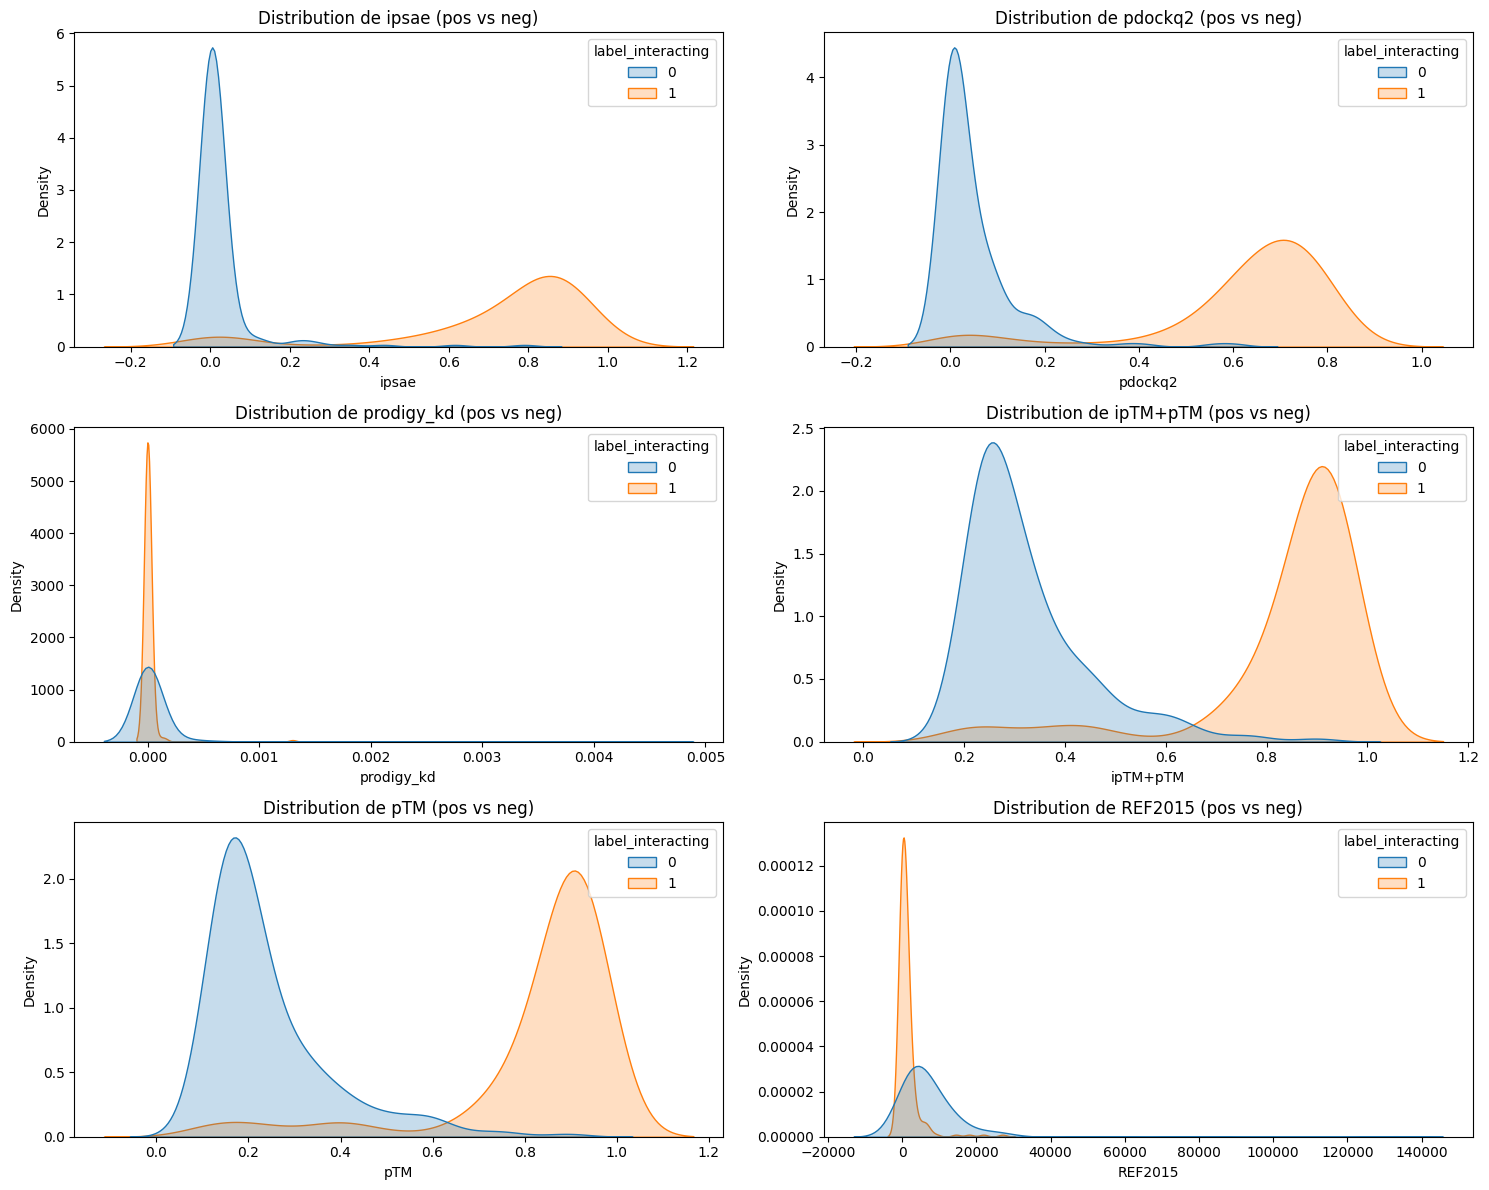

In [10]:
import seaborn as sns

plt.figure(figsize=(15, 12))

for i, col in enumerate(FEATURE_COLS, 1):
    plt.subplot(3, 2, i)
    sns.kdeplot(data=df_ml, x=col, hue="label_interacting", fill=True)
    plt.title(f"Distribution de {col} (pos vs neg)")
plt.tight_layout()
plt.show()


## Scatter plots (paires de features)

L’objectif est de visualiser les couples de variables pour voir
si les positifs et négatifs forment des clusters distincts.

C’est particulièrement utile pour diagnostiquer :
- séparabilité linéaire,
- interactions entre variables,
- bonnes candidates pour un modèle simple.


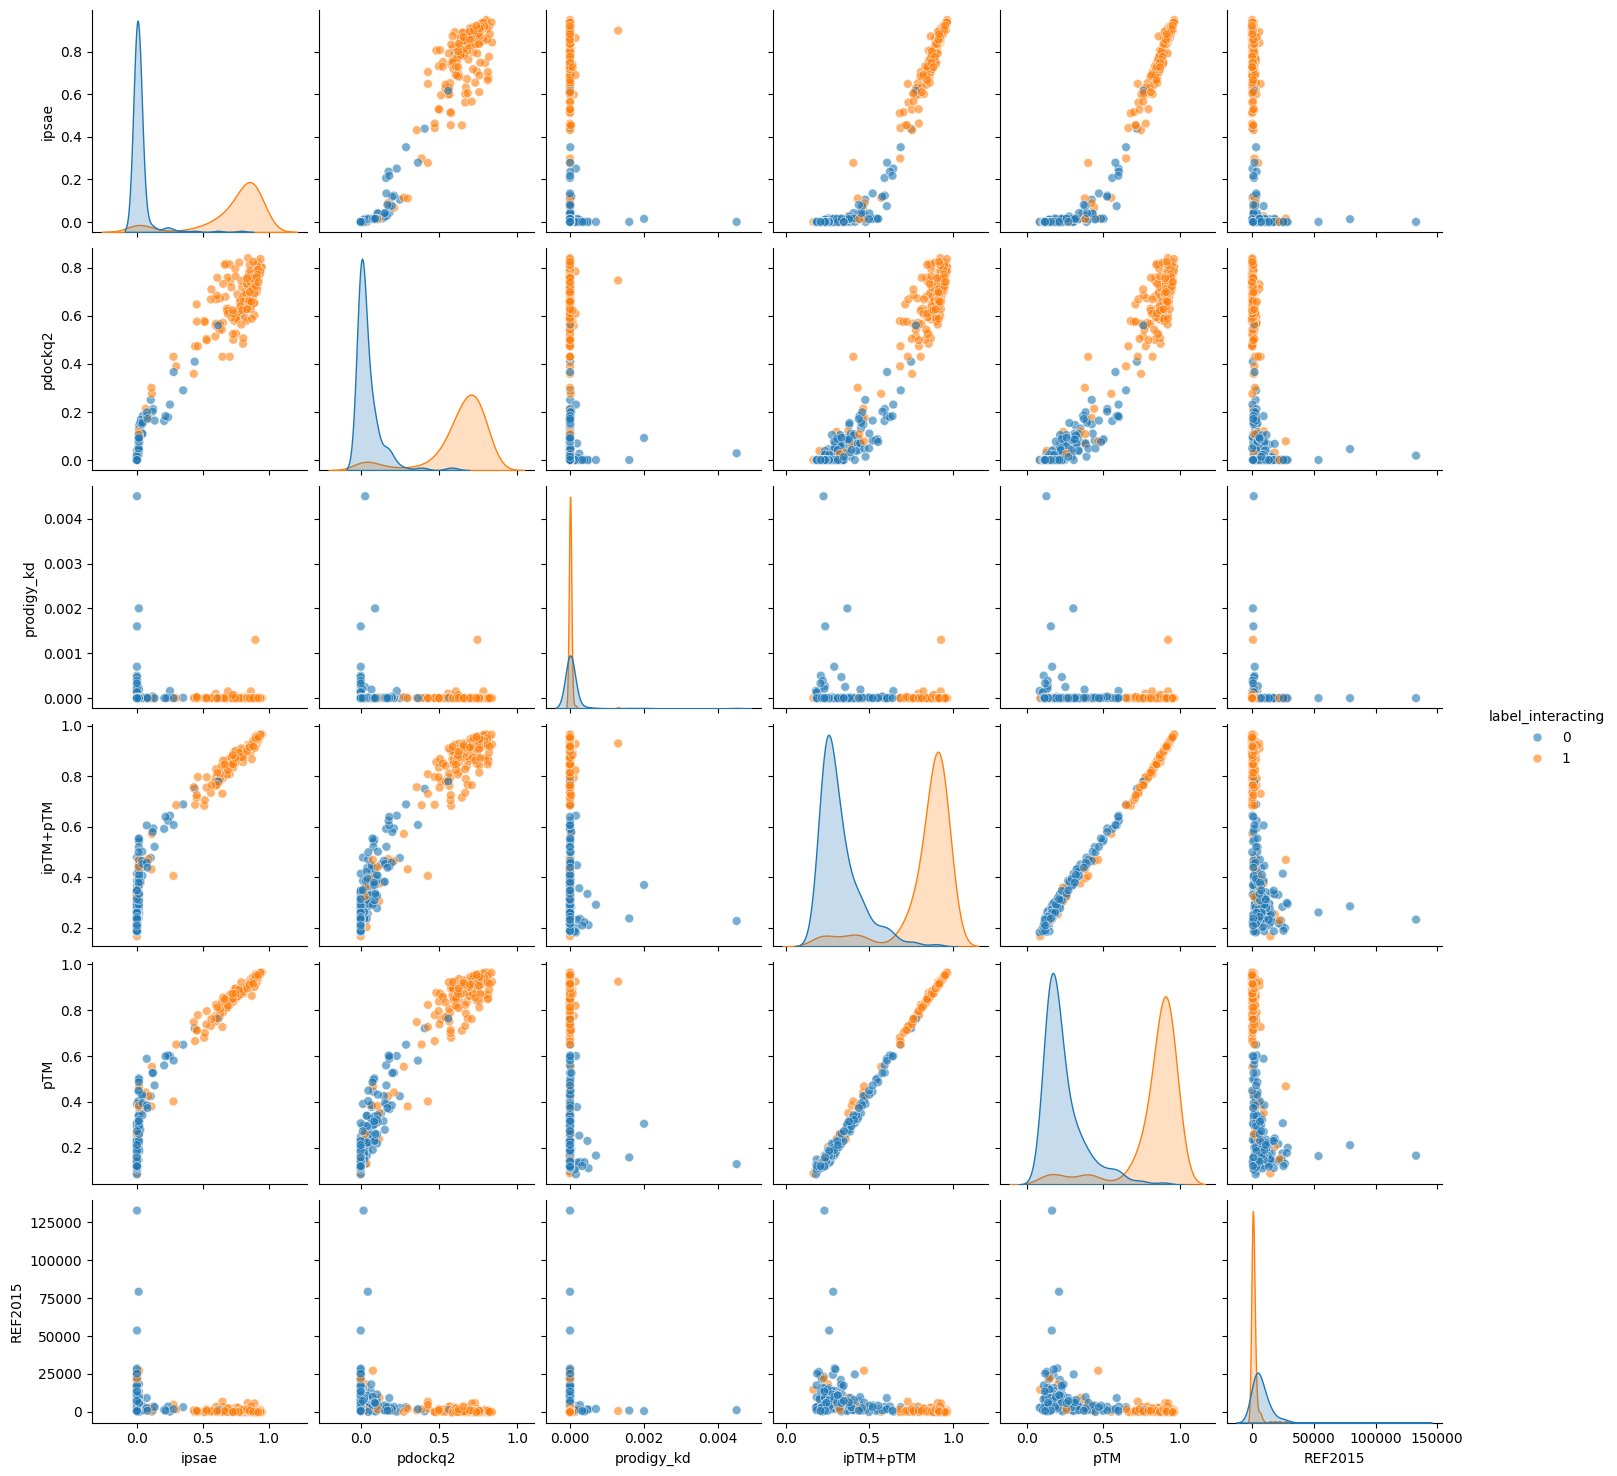

In [11]:
sns.pairplot(df_ml[FEATURE_COLS + ["label_interacting"]], 
             hue="label_interacting",
             plot_kws={'alpha': 0.6, 's': 40})
plt.show()


## Heatmap des corrélations

La heatmap montre les relations entre les features :

- valeurs proches de 1 → features fortement corrélées / redondantes  
- valeurs proches de 0 → features indépendantes

Cela permet d’anticiper :
- les features qui ne seront pas ajoutées dans le modèle glouton,
- les variables qui portent un signal “orthogonal”.


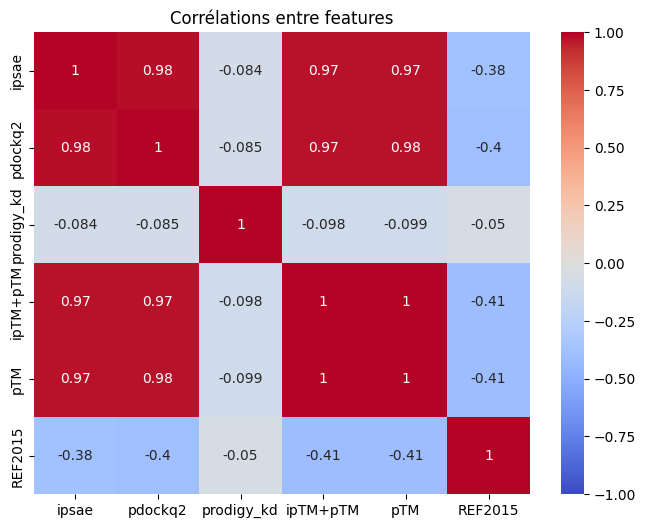

,ipsae,pdockq2,prodigy_kd,ipTM+pTM,pTM,REF2015
ipsae,1.000000,0.980224,-0.083539,0.973721,0.974512,-0.380958
pdockq2,0.980224,1.000000,-0.084705,0.974167,0.976278,-0.397963
prodigy_kd,-0.083539,-0.084705,1.000000,-0.097571,-0.098790,-0.049953
ipTM+pTM,0.973721,0.974167,-0.097571,1.000000,0.998924,-0.411724
pTM,0.974512,0.976278,-0.098790,0.998924,1.000000,-0.408921
REF2015,-0.380958,-0.397963,-0.049953,-0.411724,-0.408921,1.000000


In [12]:
plt.figure(figsize=(8, 6))
corr = df_ml[FEATURE_COLS].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Corrélations entre features")
plt.show()

corr


## Évaluation univariée des features

Pour chaque variable, nous évaluons :
- ROC AUC
- Average Precision

(en utilisant un simple modèle de seuil sur la feature)

Cela permet de mesurer **la puissance discriminante intrinsèque** de chaque feature,
indépendamment des autres.


In [13]:
from sklearn.metrics import roc_auc_score, average_precision_score

univariate_scores = []

for col in FEATURE_COLS:
    x = df_ml[col].values.reshape(-1, 1)
    scores_auc = roc_auc_score(y, x)
    scores_ap = average_precision_score(y, x)
    univariate_scores.append((col, scores_auc, scores_ap))

df_uni = pd.DataFrame(univariate_scores,
                      columns=["Feature", "AUC univarié", "AP univariée"])

df_uni.sort_values("AP univariée", ascending=False)


,Feature,AUC univarié,AP univariée
1,pdockq2,0.965566,0.974841
4,pTM,0.959522,0.972159
0,ipsae,0.962949,0.970496
3,ipTM+pTM,0.954053,0.969065
2,prodigy_kd,0.315794,0.396045
5,REF2015,0.110184,0.321034


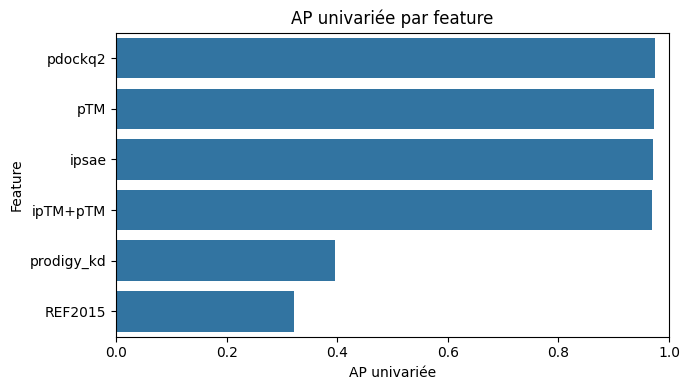

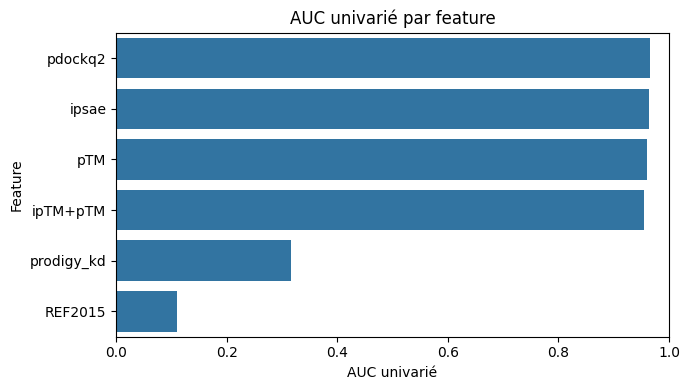

In [14]:
plt.figure(figsize=(7, 4))
sns.barplot(data=df_uni.sort_values("AP univariée", ascending=False),
            x="AP univariée", y="Feature")
plt.title("AP univariée par feature")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
sns.barplot(data=df_uni.sort_values("AUC univarié", ascending=False),
            x="AUC univarié", y="Feature")
plt.title("AUC univarié par feature")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()
